# CIV1499 - Introduction to Data Science
## Project - Toronto Bike Share

## Setup Notebook

In [1]:
# Import 3rd party libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
from fuzzywuzzy import fuzz
# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# 1. Station Data

In [419]:
stations = pd.read_csv('bikeshare_stations.csv')
stations.head()

,Station Id,Station Name,lat,lon,capacity
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954,35
1,7001,Lower Jarvis St / The Esplanade,43.647830,-79.370698,15
2,7002,St. George St / Bloor St W,43.667333,-79.399429,19
3,7003,Madison Ave / Bloor St W,43.667158,-79.402761,15
4,7004,University Ave / Elm St,43.656518,-79.389099,11


In [423]:
#check if missing values exist
stations.isnull().sum()

Station Id      0
Station Name    0
lat             0
lon             0
capacity        0
dtype: int64

# 2. Bike Share Trip Data

## 2019 Data
Task to be done:
- load all the 2019 bike share csv files and combine them in a DataFrame
- modify time columns and change the time zone to EST
- check the missing values

In [385]:
###################TASK 1#############################
#import bike share data of 2019
trips_filenames_2019 = [filename for filename in os.listdir() if 'bike_share_2019' in filename]
dfs = []
for i in trips_filenames_2019 :
    data =  pd.read_csv(i)
    dfs.append(data)
trips_data_2019 = pd.concat(dfs,axis=0,ignore_index=True)

#remove double spaces from the column names
trips_data_2019.columns = [' '.join(col.split()) for col in trips_data_2019.columns]              

#################TASK 2##############################
#localize and conver time zone
#drop the EST in the bracket, localize and convert the time in EST
est_list = []
for i in pd.DatetimeIndex(pd.to_datetime(trips_data_2019['Start Time'].map(lambda x: str(x)[:-6]),dayfirst=True)):
    est_list.append(i.tz_localize("EST"))
trips_data_2019["Start Time"] = est_list

#drop the EST in the bracket of end time, localize and convert the time in EST
est_list = []
for i in pd.DatetimeIndex(pd.to_datetime(trips_data_2019['End Time'].map(lambda x: str(x)[:-6]),dayfirst=True)):
    est_list.append(i.tz_localize("EST"))
trips_data_2019["End Time"] = est_list
# View DataFrame
trips_data_2019.head()

,Trip Id,Subscription Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
0,4581278,199751,1547,7021,2019-01-01 00:08:00-05:00,Bay St / Albert St,7233.0,2019-01-01 00:33:00-05:00,King / Cowan Ave - SMART,1296,Annual Member
1,4581279,294730,1112,7160,2019-01-01 00:10:00-05:00,King St W / Tecumseth St,7051.0,2019-01-01 00:29:00-05:00,Wellesley St E / Yonge St (Green P),2947,Annual Member
2,4581280,197252,589,7055,2019-01-01 00:15:00-05:00,Jarvis St / Carlton St,7013.0,2019-01-01 00:25:00-05:00,Scott St / The Esplanade,2293,Annual Member
3,4581281,171700,259,7012,2019-01-01 00:16:00-05:00,Elizabeth St / Edward St (Bus Terminal),7235.0,2019-01-01 00:20:00-05:00,Bay St / College St (West Side) - SMART,283,Annual Member
4,4581282,306314,281,7041,2019-01-01 00:19:00-05:00,Edward St / Yonge St,7257.0,2019-01-01 00:24:00-05:00,Dundas St W / St. Patrick St,1799,Annual Member


In [386]:
#################TASK 3##############################
#Check missing values
trips_data_2019.isnull().sum()

Trip Id                 0
Subscription Id         0
Trip Duration           0
Start Station Id        0
Start Time              0
Start Station Name      0
End Station Id        454
End Time                0
End Station Name      454
Bike Id                 0
User Type               0
dtype: int64

Before investgating those missing values, lets drop those rows which duration is shorter than 60s and use statistics to eliminate outliers.

In [387]:
def outliers_eliminate(data):
    """
    This function is used to eliminate those duration outliers in the dataset
    """
    # narrow down our dataset with 60 seconds duration filter
    data =data[data["Trip Duration"]>=60]
    #compute quartiles
    Q1 =data ["Trip Duration"].quantile(0.25)
    Q3 =data ["Trip Duration"].quantile(0.75)
    IQR = Q3 - Q1
    data  = data [data ["Trip Duration"]<=(Q3+1.5*IQR)]
    data  = data [data ["Trip Duration"]>=(Q1-1.5*IQR)]
    return data

In [388]:
trips_data_2019 = outliers_eliminate(trips_data_2019)

Investigation on those rows with missing ID

In [389]:
#Those trips without destination station name and ID
trips_data_2019[trips_data_2019["End Station Id"].isnull()==True].head()

,Trip Id,Subscription Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
61656,6795174,477797,1676,7425,2019-10-01 06:07:00-05:00,The Queensway at South Kingsway - SMART,NaN,2019-10-01 06:35:00-05:00,NaN,2133,Annual Member
62796,6796528,310361,674,7070,2019-10-01 08:20:00-05:00,25 York St – Union Station South,NaN,2019-10-01 08:31:00-05:00,NaN,4656,Annual Member
63105,6796906,407387,840,7347,2019-10-01 08:34:00-05:00,Regal Rd / Dufferin St,NaN,2019-10-01 08:48:00-05:00,NaN,1328,Annual Member
64839,6799037,363468,713,7317,2019-10-01 10:07:00-05:00,Hubbard Blvd / Balsam Av,NaN,2019-10-01 10:19:00-05:00,NaN,4073,Annual Member
66860,6801398,448729,1627,7299,2019-10-01 14:33:00-05:00,Mill St / Parliament St,NaN,2019-10-01 15:00:00-05:00,NaN,2063,Annual Member


Conparing to the entire dataset, dropping 454 rows would not cause much information loss. In this case, one appropriate method is to remove those rows without End ID and Name.

In [390]:
#romove those rows with missing ID values
trips_data_2019 = trips_data_2019[trips_data_2019["End Station Id"].isnull()==False]

## 2020 Data
Task to be done:
- load all the 2020 bike share csv files and combine them in a DataFrame
- modify time columns and change the time zone to EST
- check the missing values

In [398]:
###################TASK 1#############################
#import data 2020
trips_filenames_2020 = [filename for filename in os.listdir() if 'bike_share_2020' in filename]
dfs = []
for i in trips_filenames_2020 :
    data =  pd.read_csv(i)
    dfs.append(data)
trips_data_2020 = pd.concat(dfs,axis=0,ignore_index=True)

# Let's remove double spaces from the column names
trips_data_2020.columns = [' '.join(col.split()) for col in trips_data_2020.columns]              

#################TASK 2##############################
#localize and conver time zone
#drop the EST in the bracket
est_list = []
for i in pd.DatetimeIndex(pd.to_datetime(trips_data_2020['Start Time'].map(lambda x: str(x)[:-6]),dayfirst=True)):
    est_list.append(i.tz_localize("EST"))
trips_data_2020["Start Time"] = est_list
est_list = []
for i in pd.DatetimeIndex(pd.to_datetime(trips_data_2020['End Time'].map(lambda x: str(x)[:-6]),dayfirst=True)):
    est_list.append(i.tz_localize("EST"))
trips_data_2020["End Time"] = est_list
# View DataFrame
trips_data_2020.head()

,Trip Id,Subscription Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
0,7334128,324700,648,7003,2020-01-01 00:08:00-05:00,Madison Ave / Bloor St W,7271.0,2020-01-01 00:19:00-05:00,Yonge St / Alexander St - SMART,3104,Annual Member
1,7334129,350579,419,7007,2020-01-01 00:10:00-05:00,College St / Huron St,7163.0,2020-01-01 00:17:00-05:00,Yonge St / Wood St,2126,Annual Member
2,7334130,438337,566,7113,2020-01-01 00:13:00-05:00,Parliament St / Aberdeen Ave,7108.0,2020-01-01 00:22:00-05:00,Front St E / Cherry St,4425,Annual Member
3,7334131,452126,1274,7333,2020-01-01 00:17:00-05:00,King St E / Victoria St,7311.0,2020-01-01 00:38:00-05:00,Sherbourne St / Isabella St,4233,Annual Member
4,7334132,523945,906,7009,2020-01-01 00:19:00-05:00,King St E / Jarvis St,7004.0,2020-01-01 00:34:00-05:00,University Ave / Elm St,2341,Casual Member


Before investgating those missing values, lets drop those rows which duration is shorter than 60s and use statistics to eliminate outliers.

In [399]:
trips_data_2020 = outliers_eliminate(trips_data_2020)

In [400]:
trips_data_2020.isnull().sum()

Trip Id                 0
Subscription Id         0
Trip Duration           0
Start Station Id        0
Start Time              0
Start Station Name    158
End Station Id        387
End Time                0
End Station Name      523
Bike Id                 0
User Type               0
dtype: int64

Again, it is appropriate to drop those rows with missing values since it would only cause around 1% of information loss.

In [401]:
#use 3 filter to remove those rows with missing values
filter_1  = trips_data_2020["End Station Id"].isnull()==False
filter_2  = trips_data_2020["End Station Name"].isnull()==False
filter_3  = trips_data_2020["Start Station Name"].isnull()==False
trips_data_2020 = trips_data_2020[filter_1 & filter_2&filter_3]

## 2017 Data
Since there are some difference among the 2017, 2018, 2019 and 2020 data in terms of the order of columns and columns' names.
Furthermore, 2017 and 2018 datesets have 2 missing columns comparing to 2019 and 2020 dataset.
In this case, some modifications need to be appiled to the 2017 and 2018 dataset

Task to be done:
- load all the 2017 bike share csv files and combine them in a DataFrame
- modift the order of columns
- modify time columns and change the time zone to EST
- check the missing values

In [286]:
#obtain the columns template
col_template = trips_data_2019.columns

In [287]:
#obtain the order of columns
col_order = ['trip_id', 'Subscription Id','trip_duration_seconds', 'from_station_id', 'trip_start_time', 
             'from_station_name', 'to_station_id','trip_stop_time', 'to_station_name', 'Bike Id', 'user_type']

In [336]:
#################TASK 1##############################
#import 2017 dataset
trips_filenames_2017 = [filename for filename in os.listdir() if 'bike_share_2017' in filename]
dfs = []
for i in trips_filenames_2017:
    data =  pd.read_csv(i)
    dfs.append(data)
trips_data_2017 = pd.concat(dfs,axis=0,ignore_index=True)

#################TASK 2##############################
#add the 2 columns that are missing in 2017 and 2018
trips_data_2017.insert(loc=1,column='Subscription Id',value=np.nan)
trips_data_2017.insert(loc=9,column='Bike Id',value=np.nan)

#organize the order of columns
trips_data_finalized_2017 = trips_data_2017[col_order]

#rename the columns in order to match the template
trips_data_finalized_2017.columns = col_template

In [337]:
#################TASK 3##############################
#localize and conver time zone
#drop the UTC in the bracket
est_list = []
for i in pd.DatetimeIndex(pd.to_datetime(trips_data_finalized_2017['Start Time'].map(lambda x: str(x)[:-6]),dayfirst=True)):
    est_list.append(i.tz_localize("UTC").tz_convert("EST"))
trips_data_finalized_2017["Start Time"] = est_list
est_list = []
for i in pd.DatetimeIndex(pd.to_datetime(trips_data_finalized_2017['End Time'].map(lambda x: str(x)[:-6]),dayfirst=True)):
    est_list.append(i.tz_localize("UTC").tz_convert("EST"))
trips_data_finalized_2017["End Time"] = est_list

In [338]:
trips_data_finalized_2017.head()

,Trip Id,Subscription Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
0,712441,NaN,274,7006.0,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,NaN,Member
1,712442,NaN,538,7046.0,2017-01-01 00:03:00-05:00,Niagara St / Richmond St W,7147.0,2017-01-01 00:12:00-05:00,King St W / Fraser Ave,NaN,Member
2,712443,NaN,992,7048.0,2017-01-01 00:05:00-05:00,Front St / Yonge St (Hockey Hall of Fame),7089.0,2017-01-01 00:22:00-05:00,Church St / Wood St,NaN,Member
3,712444,NaN,1005,7177.0,2017-01-01 00:09:00-05:00,East Liberty St / Pirandello St,7202.0,2017-01-01 00:26:00-05:00,Queen St W / York St (City Hall),NaN,Member
4,712445,NaN,645,7203.0,2017-01-01 00:14:00-05:00,Bathurst St / Queens Quay W,7010.0,2017-01-01 00:25:00-05:00,King St W / Spadina Ave,NaN,Member


In [339]:
trips_data_finalized_2017.isnull().sum()

Trip Id                     0
Subscription Id       1492369
Trip Duration               0
Start Station Id      1026893
Start Time                  0
Start Station Name          0
End Station Id        1026893
End Time                    1
End Station Name            1
Bike Id               1492369
User Type                   0
dtype: int64

It is obvious that this data porint has some error since the duration of this trip is 0 second. For the missing value in End Time, it is appropriate to drop this row.

In [340]:
#remove the row without the End Time
trips_data_finalized_2017 = trips_data_finalized_2017[trips_data_finalized_2017['End Time'].isnull()==False]

Now, it is time to work on the name update process. As mentioned in the project file, there are some name inconsistency issue with the station name column. Therefor it is important to update those names in order to make future task easier. Before that, lets drop those rows which duration is shorter than 60s and use statistics to eliminate outliers.

In [342]:
#eliminate outliers and save the dataset
trips_data_finalized_2017 = outliers_eliminate(trips_data_finalized_2017)

In [347]:
#compute the percentage of the dataset we drop
(1-trips_data_finalized_2017.shape[0]/1492369)*100

7.655010255506511

So far, we drop nearly 8 persent of our data which is regarded as outliers and error data points. Now, the update process should be conducted.

In [348]:
#obtain a updated station name list from station dataset
name_list = stations['Station Name'].unique()

In [364]:
#create a function for updating a name
def name_update(old_name,name_list):
    """This function is used to update an old_name with the
    new name in name_list
    """
    result_dict  = {0:'Base Station'}
    if old_name in name_list:
        return old_name
    else:
        for new_name in name_list:
            if fuzz.ratio(new_name,old_name) >= 60:
                result_dict[fuzz.ratio(new_name,old_name)] = str(new_name)
    possible_result = result_dict[max(result_dict.keys())]
    return possible_result


    
#create a function for replacing the name
def name_replace(old_name):
    """This function is used to replace the old station name
    """
    return stations_old[stations_old['Name'] == old_name]['New Name'].tolist()[0]



#create a function for replace the missing ID
def ID_replace(new_name):
    """This function is used to replace the missing ID
    """
    if new_name == np.nan:
        return np.nan
    elif new_name == "Base Station":
        return np.nan
    else:
        return stations["Station Id"][stations['Station Name'] == new_name].tolist()[0]

In [350]:
######First lets check how many names need to be updated######
updated_index = trips_data_finalized_2017[trips_data_finalized_2017['Start Station Name'].apply(lambda row: row not in name_list)].index
print(len(updated_index))

340054


There are 340054 rows which need to update the start station name.
To increase the efficiency, the first step is to extract the unique station name in both starting and ending points.

In [365]:
#extracting both starting names and ending names
stations_start = trips_data_finalized_2017[['Start Station Id', 'Start Station Name']]
stations_end = trips_data_finalized_2017[['End Station Id', 'End Station Name']]
stations_start.columns = stations_end.columns = ['Station Id', 'Name']

# combine them  in to a single dataframe
stations_old = pd.concat([stations_start, stations_end]).dropna(how='all').drop_duplicates().reset_index(drop=True)
stations_old = stations_old.drop_duplicates(subset="Name")

Update the names in the Station Old DataFrame and save them into a new column called "New name".

In [366]:
#Update the names
stations_old['New Name'] = stations_old['Name'].apply(lambda row: name_update(row,name_list))

In [358]:
#view the dataframe
stations_old.head()

,Station Id,Name,New Name
0,7006.0,Bay St / College St (East Side),Bay St / College St (East Side)
1,7046.0,Niagara St / Richmond St W,Niagara St / Richmond St W
2,7048.0,Front St / Yonge St (Hockey Hall of Fame),Front St W / Yonge St (Hockey Hall of Fame)
3,7177.0,East Liberty St / Pirandello St,East Liberty St / Pirandello St
4,7203.0,Bathurst St / Queens Quay W,York St / Queens Quay W


Based on this DataFrame, we can use this as a translator to update every single name in our original dataset.

In [368]:
#updating the start station old name
trips_data_finalized_2017['Start Station Name'] = trips_data_finalized_2017['Start Station Name'].apply(lambda row: name_replace(row))

In [369]:
#updating the End station old name
trips_data_finalized_2017['End Station Name'] = trips_data_finalized_2017['End Station Name'].apply(lambda row: name_replace(row))

In [370]:
#view dataset
trips_data_finalized_2017.head()

,Trip Id,Subscription Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
0,712441,NaN,274,7006.0,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,NaN,Member
1,712442,NaN,538,7046.0,2017-01-01 00:03:00-05:00,Niagara St / Richmond St W,7147.0,2017-01-01 00:12:00-05:00,King St W / Fraser Ave,NaN,Member
2,712443,NaN,992,7048.0,2017-01-01 00:05:00-05:00,Front St W / Yonge St (Hockey Hall of Fame),7089.0,2017-01-01 00:22:00-05:00,Church St / Wood St,NaN,Member
3,712444,NaN,1005,7177.0,2017-01-01 00:09:00-05:00,East Liberty St / Pirandello St,7202.0,2017-01-01 00:26:00-05:00,Queen St W / York St (City Hall),NaN,Member
4,712445,NaN,645,7203.0,2017-01-01 00:14:00-05:00,York St / Queens Quay W,7010.0,2017-01-01 00:25:00-05:00,King St W / Spadina Ave,NaN,Member


In the third row, the start station name used to be 'Front St / Yonge St (Hockey Hall of Fame)' right now is 'Front St W / Yonge St (Hockey Hall of Fame)', therefore our updating process is working. Next, filling those rows with missing ID.

In [371]:
#updating IDs
trips_data_finalized_2017['Start Station Id'] = trips_data_finalized_2017['Start Station Name'].apply(lambda row: ID_replace(row))
trips_data_finalized_2017['End Station Id'] = trips_data_finalized_2017['End Station Name'].apply(lambda row: ID_replace(row))

Lastly, drop those rows without Starting and End station names and IDs

In [ ]:
#drop any rows without any station name or ID
mask1 = trips_data_finalized_2017['Start Station Id'].isnull()==False
mask2 = trips_data_finalized_2017['End Station Id'].isnull()==False
trips_data_finalized_2017 = trips_data_finalized_2017[mask1 & mask2]

## 2018 Data
Since there are some difference among the 2017, 2018, 2019 and 2020 data in terms of the order of columns and columns' names.
Furthermore, 2017 and 2018 datesets have 2 missing columns comparing to 2019 and 2020 dataset.
In this case, some modifications need to be appiled to the 2017 and 2018 dataset

Task to be done:
- load all the 2018 bike share csv files and combine them in a DataFrame
- modift the order of columns
- modify time columns and change the time zone to EST
- check the missing values

In [393]:
#2018
#################TASK 1##############################
trips_filenames_2018 = [filename for filename in os.listdir() if 'bike_share_2018' in filename]
dfs = []
for i in trips_filenames_2018:
    data =  pd.read_csv(i)
    dfs.append(data)
trips_data_2018 = pd.concat(dfs,axis=0,ignore_index=True)
#################TASK 2##############################
#add 2 missing columns
trips_data_2018.insert(loc=1,column='Subscription Id',value=np.nan)
trips_data_2018.insert(loc=9,column='Bike Id',value=np.nan)
#modify columns
trips_data_finalized_2018 = trips_data_2018[col_order]
trips_data_finalized_2018.columns = col_template

In [394]:
#################TASK 3##############################
#localize and conver time zone
#drop the EST in the bracket
est_list = []
for i in pd.DatetimeIndex(pd.to_datetime(trips_data_finalized_2018['Start Time'].map(lambda x: str(x)[:-6]),dayfirst=True)):
    est_list.append(i.tz_localize("UTC").tz_convert("EST"))
trips_data_finalized_2018["Start Time"] = est_list
est_list = []
for i in pd.DatetimeIndex(pd.to_datetime(trips_data_finalized_2018['End Time'].map(lambda x: str(x)[:-6]),dayfirst=True)):
    est_list.append(i.tz_localize("UTC").tz_convert("EST"))
trips_data_finalized_2018["End Time"] = est_list

In [395]:
#view the dataset
trips_data_finalized_2018.head()

,Trip Id,Subscription Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
0,2383648,NaN,393,7018,2018-01-01 00:47:00-05:00,Bremner Blvd / Rees St,7176,2018-01-01 00:54:00-05:00,Bathurst St / Fort York Blvd,NaN,Annual Member
1,2383649,NaN,625,7184,2018-01-01 00:52:00-05:00,Ossington Ave / College St,7191,2018-01-01 01:03:00-05:00,Central Tech (Harbord St),NaN,Annual Member
2,2383650,NaN,233,7235,2018-01-01 00:55:00-05:00,Bay St / College St (West Side) - SMART,7021,2018-01-01 00:59:00-05:00,Bay St / Albert St,NaN,Annual Member
3,2383651,NaN,1138,7202,2018-01-01 00:57:00-05:00,Queen St W / York St (City Hall),7020,2018-01-01 01:16:00-05:00,Phoebe St / Spadina Ave,NaN,Annual Member
4,2383652,NaN,703,7004,2018-01-01 01:00:00-05:00,University Ave / Elm St,7060,2018-01-01 01:12:00-05:00,Princess St / Adelaide St E,NaN,Annual Member


Before investgating those missing values, lets drop those rows which duration is shorter than 60s and use statistics to eliminate outliers.

In [396]:
#eliminate outliers
trips_data_finalized_2018 = outliers_eliminate(trips_data_finalized_2018)

In [397]:
trips_data_finalized_2018.isnull().sum()

Trip Id                     0
Subscription Id       1826363
Trip Duration               0
Start Station Id            0
Start Time                  0
Start Station Name          0
End Station Id              0
End Time                    0
End Station Name            0
Bike Id               1826363
User Type                   0
dtype: int64

Comparing to other dataset, 2018 bike share does not have any missing values in ID and Names columns. So far, four years' dataset are prepared.

In [416]:
#Combining four years' data together
finalized_bike_data = pd.concat([trips_data_finalized_2017,trips_data_finalized_2018,trips_data_2019,trips_data_2020],axis=0,ignore_index=True)

In [426]:
#final check on missing values in different columns
finalized_bike_data .isnull().sum()

Trip Id                     0
Subscription Id       3183621
Trip Duration               0
Start Station Id            0
Start Time                  0
Start Station Name          0
End Station Id              0
End Time                    0
End Station Name            0
Bike Id               3183621
User Type                   0
dtype: int64

In [427]:
#view the final dataset
finalized_bike_data.head()

,Trip Id,Subscription Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type
0,712441,NaN,274,7006.0,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,NaN,Member
1,712442,NaN,538,7046.0,2017-01-01 00:03:00-05:00,Niagara St / Richmond St W,7147.0,2017-01-01 00:12:00-05:00,King St W / Fraser Ave,NaN,Member
2,712443,NaN,992,7048.0,2017-01-01 00:05:00-05:00,Front St W / Yonge St (Hockey Hall of Fame),7089.0,2017-01-01 00:22:00-05:00,Church St / Wood St,NaN,Member
3,712444,NaN,1005,7177.0,2017-01-01 00:09:00-05:00,East Liberty St / Pirandello St,7202.0,2017-01-01 00:26:00-05:00,Queen St W / York St (City Hall),NaN,Member
4,712445,NaN,645,7076.0,2017-01-01 00:14:00-05:00,York St / Queens Quay W,7010.0,2017-01-01 00:25:00-05:00,King St W / Spadina Ave,NaN,Member


# 3. Weather Data

# Step 1: Import weather data 

In [402]:
# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")

# Step 2: Load weather data 

In [403]:
# Get the file names for the weather files and load them into the notebook as one dataframe
weather_filenames = [filename for filename in os.listdir() if '6158359' in filename]
weather_data = pd.concat(map(pd.read_csv, weather_filenames))
weather_data.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Time,Temp (°C),...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 00:00,2017,1,1,00:00,1.5,...,NaN,16.1,NaN,99.81,NaN,NaN,NaN,NaN,NaN,NaN
1,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 01:00,2017,1,1,01:00,1.5,...,NaN,16.1,NaN,100.01,NaN,NaN,NaN,NaN,NaN,NaN
2,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 02:00,2017,1,1,02:00,1.0,...,NaN,16.1,NaN,100.14,NaN,NaN,NaN,NaN,NaN,NaN
3,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 03:00,2017,1,1,03:00,1.2,...,NaN,16.1,NaN,100.32,NaN,NaN,NaN,NaN,NaN,NaN
4,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 04:00,2017,1,1,04:00,1.3,...,NaN,16.1,NaN,100.48,NaN,NaN,NaN,NaN,NaN,NaN


# Step 3: Clean weather data

In [404]:
# Localize the date and time and set as the index as well as removing the column afterwards
weather_data.index = pd.DatetimeIndex(weather_data['Date/Time'])
weather_data.drop('Date/Time', axis = 1, inplace = True)
weather_data.index = weather_data.index.tz_localize('EST')
weather_data.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Time,Temp (°C),Temp Flag,...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
Date/Time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017,1,1,00:00,1.5,NaN,...,NaN,16.1,NaN,99.81,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017,1,1,01:00,1.5,NaN,...,NaN,16.1,NaN,100.01,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017,1,1,02:00,1.0,NaN,...,NaN,16.1,NaN,100.14,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 03:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017,1,1,03:00,1.2,NaN,...,NaN,16.1,NaN,100.32,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 04:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017,1,1,04:00,1.3,NaN,...,NaN,16.1,NaN,100.48,NaN,NaN,NaN,NaN,NaN,NaN


## Keep important columns only

Some columns contain redundant or not useful information. For example, the 'Climate ID' column contains the number assigned to the weather station, but all of the weather data come from the same station; therefore, this column is redundant and should be removed. 

To determine what to keep and what to discard, first the non-numerical data type columns are investigated followed by the numerical data type columns.

In [405]:
# Create a dataframe containing non-numerical data type columns to investigate
non_num = weather_data.select_dtypes(exclude = 'number')
display(non_num.head())

# Check the unique values of each column
print(non_num.apply(lambda  col: col.unique()))

,Station Name,Time,Temp Flag,Dew Point Temp Flag,Rel Hum Flag,Wind Dir Flag,Wind Spd Flag,Visibility Flag,Stn Press Flag,Weather
Date/Time,,,,,,,,,,
2017-01-01 00:00:00-05:00,TORONTO CITY CENTRE,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00-05:00,TORONTO CITY CENTRE,01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:00:00-05:00,TORONTO CITY CENTRE,02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 03:00:00-05:00,TORONTO CITY CENTRE,03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 04:00:00-05:00,TORONTO CITY CENTRE,04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Station Name                                       [TORONTO CITY CENTRE]
Time                   [00:00, 01:00, 02:00, 03:00, 04:00, 05:00, 06:...
Temp Flag                                                       [nan, M]
Dew Point Temp Flag                                             [nan, M]
Rel Hum Flag                                                    [nan, M]
Wind Dir Flag                                                   [nan, M]
Wind Spd Flag                                                   [nan, M]
Visibility Flag                                                 [nan, M]
Stn Press Flag                                                  [nan, M]
Weather                [nan, Fog, Rain,Fog, Rain, Snow, Moderate Rain...
dtype: object


The 'Time' column corresponds to the hour of observation, which is already included in the 'Date/Time' index. The 'Weather' column is the visual observation of the weather environment and appears to be important. The 'Station Name' column shows the name of the weather station which is redundant since the weather data were all taken from the same station. There are a number of columns containing the word 'Flag', and only contains NaN or 'M' values. According to Environment and Climate Change Canada, the 'M' represents 'missing' which means the data is unretrievable or unavailable (https://climate.weather.gc.ca/FAQ_e.html#Q4). Additionally, it appears that there are some 'Flag' columns that were not included, so those should be investigated as well.

In [406]:
# Look at the number of NaN values in the columns containing the word 'Flag'
flag_columns = [col for col in weather_data.columns if 'Flag' in col]
weather_data[flag_columns].isnull().sum(axis=0).to_frame('count')

,count
Temp Flag,34975
Dew Point Temp Flag,34925
Rel Hum Flag,34933
Wind Dir Flag,34010
Wind Spd Flag,35049
Visibility Flag,35042
Stn Press Flag,34971
Hmdx Flag,35064
Wind Chill Flag,35064


These other columns should be removed as well. Overall, based on the investigation, the only column that should be kept is the 'Weather' column. 

In [407]:
# Drop the non-useful columns
clean_weather_data = weather_data.drop(set(flag_columns + list(non_num.columns.drop('Weather'))), axis = 1)
display(clean_weather_data.head())
print(clean_weather_data.nunique())

,Longitude (x),Latitude (y),Climate ID,Year,Month,Day,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather
Date/Time,,,,,,,,,,,,,,,,
2017-01-01 00:00:00-05:00,-79.4,43.63,6158359,2017,1,1,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,NaN
2017-01-01 01:00:00-05:00,-79.4,43.63,6158359,2017,1,1,1.5,-3.9,67.0,27.0,35.0,16.1,100.01,NaN,NaN,NaN
2017-01-01 02:00:00-05:00,-79.4,43.63,6158359,2017,1,1,1.0,-4.3,68.0,26.0,32.0,16.1,100.14,NaN,NaN,NaN
2017-01-01 03:00:00-05:00,-79.4,43.63,6158359,2017,1,1,1.2,-4.3,67.0,26.0,37.0,16.1,100.32,NaN,NaN,NaN
2017-01-01 04:00:00-05:00,-79.4,43.63,6158359,2017,1,1,1.3,-4.4,66.0,26.0,28.0,16.1,100.48,NaN,NaN,NaN


Longitude (x)            1
Latitude (y)             1
Climate ID               1
Year                     4
Month                   12
Day                     31
Temp (°C)              526
Dew Point Temp (°C)    520
Rel Hum (%)             84
Wind Dir (10s deg)      36
Wind Spd (km/h)         40
Visibility (km)         22
Stn Press (kPa)        553
Hmdx                    19
Wind Chill              36
Weather                 24
dtype: int64


With the number of columns greatly reduced, the rest can be individually selected. The 'Year', 'Month', 'Day', and 'Climate ID' columns can be removed. The 'Longitude (x)' and 'Latitude (y)' could also be removed since the coordinates of the weather station remain the same. Additionally, 'Stn Press (kPa)' is not important because small atmospheric pressure changes have infinitesimal effects on everyday activities. Given the small elevation difference across Toronto, pressure due to elevation change is insignificant.

In [408]:
# Drop the rest of the non-useful columns
clean_weather_data.drop(['Year', 'Month', 'Day', 'Climate ID', 'Longitude (x)', 'Latitude (y)', 'Stn Press (kPa)'], 
                        axis = 1, inplace = True)
clean_weather_data.head()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather
Date/Time,,,,,,,,,
2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,NaN
2017-01-01 01:00:00-05:00,1.5,-3.9,67.0,27.0,35.0,16.1,NaN,NaN,NaN
2017-01-01 02:00:00-05:00,1.0,-4.3,68.0,26.0,32.0,16.1,NaN,NaN,NaN
2017-01-01 03:00:00-05:00,1.2,-4.3,67.0,26.0,37.0,16.1,NaN,NaN,NaN
2017-01-01 04:00:00-05:00,1.3,-4.4,66.0,26.0,28.0,16.1,NaN,NaN,NaN


## Treating missing data

Now that the redundant and non-useful columns are removed, the final step is to determine what to do with missing values.

### Locate missing values

In [409]:
# Check missing values
display(clean_weather_data.isnull().sum(axis=0).to_frame('count'))
display(clean_weather_data.resample('Y').agg(lambda row: row.isnull().sum()))

,count
Temp (°C),459
Dew Point Temp (°C),508
Rel Hum (%),500
Wind Dir (10s deg),2385
Wind Spd (km/h),384
Visibility (km),391
Hmdx,29397
Wind Chill,28998
Weather,29547


,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather
Date/Time,,,,,,,,,
2017-12-31 00:00:00-05:00,11.0,11.0,10.0,530.0,9.0,11.0,7599.0,7251.0,7390
2018-12-31 00:00:00-05:00,4.0,4.0,2.0,504.0,2.0,4.0,6979.0,7084.0,7336
2019-12-31 00:00:00-05:00,95.0,145.0,145.0,595.0,23.0,24.0,7608.0,6936.0,7213
2020-12-31 00:00:00-05:00,349.0,348.0,343.0,756.0,350.0,352.0,7211.0,7727.0,7608


There appears to be a lot of missing data in 2019 and 2020 compared to the other years, particularly the latter. Also, 'Hmdx', 'Wind Chill', and 'Weather columns have significantly more missing values than the other columns.

In [410]:
# Check monthly weather data in 2019 and 2020 for missing values
display(clean_weather_data.loc['2019'].resample('M').agg(lambda row: row.isnull().sum()))
display(clean_weather_data.loc['2020'].resample('M').agg(lambda row: row.isnull().sum()))

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather
Date/Time,,,,,,,,,
2019-01-31 00:00:00-05:00,0.0,0.0,0.0,21.0,0.0,0.0,744.0,197.0,522
2019-02-28 00:00:00-05:00,0.0,0.0,0.0,24.0,0.0,0.0,672.0,202.0,455
2019-03-31 00:00:00-05:00,1.0,1.0,1.0,33.0,3.0,4.0,744.0,417.0,633
2019-04-30 00:00:00-05:00,0.0,0.0,0.0,43.0,0.0,0.0,720.0,707.0,568
2019-05-31 00:00:00-05:00,28.0,28.0,28.0,88.0,12.0,12.0,741.0,744.0,570
2019-06-30 00:00:00-05:00,59.0,109.0,109.0,74.0,1.0,1.0,624.0,720.0,629
2019-07-31 00:00:00-05:00,7.0,7.0,7.0,103.0,7.0,7.0,233.0,744.0,671
2019-08-31 00:00:00-05:00,0.0,0.0,0.0,75.0,0.0,0.0,334.0,744.0,690
2019-09-30 00:00:00-05:00,0.0,0.0,0.0,49.0,0.0,0.0,598.0,720.0,667


,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather
Date/Time,,,,,,,,,
2020-01-31 00:00:00-05:00,5.0,5.0,0.0,25.0,5.0,3.0,744.0,429.0,590
2020-02-29 00:00:00-05:00,0.0,0.0,0.0,9.0,0.0,0.0,696.0,293.0,518
2020-03-31 00:00:00-05:00,0.0,0.0,0.0,27.0,2.0,0.0,744.0,643.0,613
2020-04-30 00:00:00-05:00,0.0,0.0,0.0,31.0,0.0,0.0,720.0,694.0,639
2020-05-31 00:00:00-05:00,0.0,0.0,0.0,43.0,0.0,0.0,701.0,734.0,649
2020-06-30 00:00:00-05:00,7.0,6.0,6.0,64.0,6.0,5.0,489.0,720.0,674
2020-07-31 00:00:00-05:00,0.0,0.0,0.0,43.0,0.0,0.0,53.0,744.0,718
2020-08-31 00:00:00-05:00,0.0,0.0,0.0,58.0,0.0,7.0,249.0,744.0,694
2020-09-30 00:00:00-05:00,0.0,0.0,0.0,49.0,0.0,0.0,610.0,720.0,641


In 2019, there appears to be numerous missing data in May and June, while in 2020 there is a significant loss of data in December.

In [411]:
# Check daily weather data in December 2020 for missing values
display(clean_weather_data.loc['2020-12'].resample('D').agg(lambda row: row.isnull().sum()))

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather
Date/Time,,,,,,,,,
2020-12-01 00:00:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,24.0,8.0,1
2020-12-02 00:00:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,24.0,18.0,19
2020-12-03 00:00:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,24.0,24.0,24
2020-12-04 00:00:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,24.0,24.0,13
2020-12-05 00:00:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,24.0,16.0,24
2020-12-06 00:00:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,24.0,5.0,24
2020-12-07 00:00:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,24.0,3.0,24
2020-12-08 00:00:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,24.0,12.0,24
2020-12-09 00:00:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,24.0,24.0,10


It seems that from December 18, 2020 onwards, no weather data of any kind is recorded (weather data is reported hourly, so there should be 24 reports per day). Since the 2020 bikeshare data is currently missing November and December 2020 data, the November and December 2020 weather data will not be used; therefore, the missing values are insignificant in this case.

### Imputing/filling missing values

***Humidex and Wind Chill***

<AxesSubplot:title={'center':'Number of missing values for humidex and wind chill columns in 2020'}, xlabel='Month', ylabel='Count'>

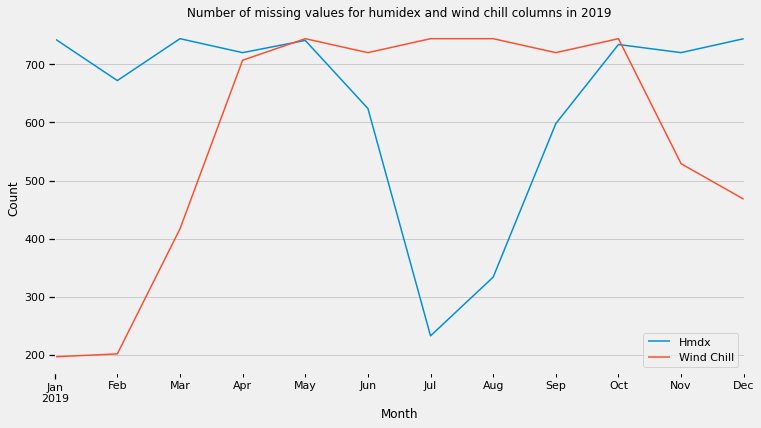

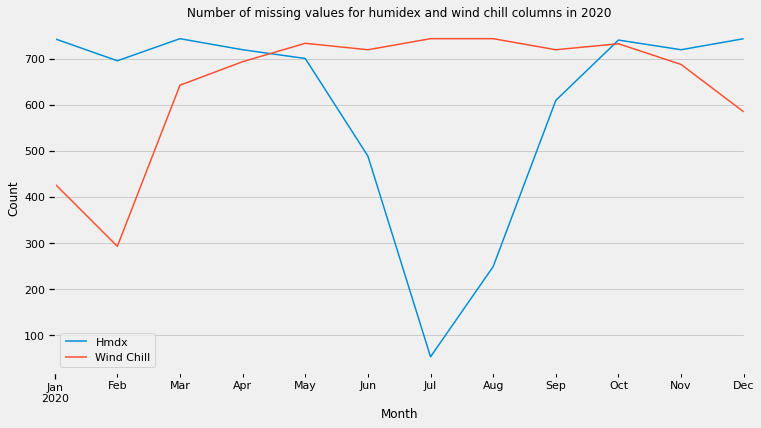

In [412]:
# Visualizing number of missing values in 'Hmdx' and 'Wind Chill' columns
clean_weather_data.loc['2019'].resample('M').agg(
    lambda row: row.isnull().sum())[['Hmdx', 'Wind Chill']].plot(
    figsize = (11, 6), title = 'Number of missing values for humidex and wind chill columns in 2019', 
    xlabel = 'Month', ylabel = 'Count')

clean_weather_data.loc['2020'].resample('M').agg(
    lambda row: row.isnull().sum())[['Hmdx', 'Wind Chill']].plot(
    figsize = (11, 6), title = 'Number of missing values for humidex and wind chill columns in 2020', 
    xlabel = 'Month', ylabel = 'Count')

It appears that there are more missing wind chill values and fewer missing humidex values in the summer and vice versa in the winter. This makes sense as humidex is mainly an indicator of how hot a person would feel, while wind chill indicates how cold a person would feel. 

According to Environment and Climate Change Canada (https://climate.weather.gc.ca/glossary_e.html), the humidex values are only reported if (1) air temperature is greater than or equal to 20 degrees celsius and (2) the humidex value is at least 1 degree greater than the air temperature. Similarily, wind chill is only calculated if the air temperature is greater than or equal to 0 degrees celsius. As a result, the missing values in 'Hmdx' and 'Wind Chill' should not be modified.


***Weather***

For the 'Weather' column, the missing values indicate that no weather phenomena were reported (https://climate.weather.gc.ca/FAQ_e.html#Q5). This is assumed to be clear weather, and subsequently any missing values will be replaced with 'Clear'.

In [413]:
# Modifying missing values in 'Weather' column
clean_weather_data['Weather'].fillna('Clear', inplace = True)
clean_weather_data.head()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather
Date/Time,,,,,,,,,
2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear
2017-01-01 01:00:00-05:00,1.5,-3.9,67.0,27.0,35.0,16.1,NaN,NaN,Clear
2017-01-01 02:00:00-05:00,1.0,-4.3,68.0,26.0,32.0,16.1,NaN,NaN,Clear
2017-01-01 03:00:00-05:00,1.2,-4.3,67.0,26.0,37.0,16.1,NaN,NaN,Clear
2017-01-01 04:00:00-05:00,1.3,-4.4,66.0,26.0,28.0,16.1,NaN,NaN,Clear


***The rest of the columns***

Due to the frequency of weather reports, the change in magnitude should not be significant between each hour (wind direction and wind speed may change slightly more). For example, if the temperature at 10 AM is 10 degrees celsius, then it would be unlikely that the 11 AM temperature suddenly increases to 20 degrees celsius. Therefore, it should be reasonable to impute missing values based on the time-adjacent valid observations. Except for 'Hmdx', 'Wind Chill', and 'Weather' columns, all other columns will have missing values filled using linear interpolation between valid observations.

In [414]:
# Linear interpolating values 
col_interp = clean_weather_data.columns.drop(['Hmdx', 'Wind Chill', 'Weather'])
clean_weather_data[col_interp] = clean_weather_data[col_interp].interpolate(
    method = 'linear', axis = 0, limit_direction = 'both').round(1)

Now there should not be any missing values in the data except for 'Hmdx' and 'Wind Chill' columns.

In [415]:
# Check if there are still missing values
display(clean_weather_data.resample('Y').agg(lambda row: row.isnull().sum()))

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather
Date/Time,,,,,,,,,
2017-12-31 00:00:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,7599.0,7251.0,0
2018-12-31 00:00:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,6979.0,7084.0,0
2019-12-31 00:00:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,7608.0,6936.0,0
2020-12-31 00:00:00-05:00,0.0,0.0,0.0,0.0,0.0,0.0,7211.0,7727.0,0


In [425]:
#view the data
clean_weather_data.head()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather
Date/Time,,,,,,,,,
2017-01-01 00:00:00-05:00,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear
2017-01-01 01:00:00-05:00,1.5,-3.9,67.0,27.0,35.0,16.1,NaN,NaN,Clear
2017-01-01 02:00:00-05:00,1.0,-4.3,68.0,26.0,32.0,16.1,NaN,NaN,Clear
2017-01-01 03:00:00-05:00,1.2,-4.3,67.0,26.0,37.0,16.1,NaN,NaN,Clear
2017-01-01 04:00:00-05:00,1.3,-4.4,66.0,26.0,28.0,16.1,NaN,NaN,Clear


# 4. Combine the three datasets

## Merging Bike Share and Station

In [444]:
#modify the station data and coluimns and extract the useful information
stations_start = stations[["Station Id",'lat','lon','capacity']]
stations_start.columns = ["Start Station Id",'Start_lat','Start_lon','Start_capacity']
stations_end = stations[["Station Id",'lat','lon','capacity']]
stations_end.columns = ["End Station Id",'End_lat','End_lon','End_capacity']

In [445]:
#merging with the bike share data
df_1 = finalized_bike_data.merge(stations_start, how='inner', on='Start Station Id')
df_2 = df_1.merge(stations_end, how='inner', on='End Station Id')

In [447]:
#view the dataset
df_2.head()

,Trip Id,Subscription Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,Start_lat,Start_lon,Start_capacity,End_lat,End_lon,End_capacity
0,712441,NaN,274,7006.0,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,NaN,Member,43.660439,-79.385525,11,43.653264,-79.382458,35
1,717862,NaN,252,7006.0,2017-01-05 18:06:00-05:00,Bay St / College St (East Side),7021.0,2017-01-05 18:11:00-05:00,Bay St / Albert St,NaN,Member,43.660439,-79.385525,11,43.653264,-79.382458,35
2,719500,NaN,241,7006.0,2017-01-06 18:46:00-05:00,Bay St / College St (East Side),7021.0,2017-01-06 18:50:00-05:00,Bay St / Albert St,NaN,Member,43.660439,-79.385525,11,43.653264,-79.382458,35
3,722310,NaN,262,7006.0,2017-01-09 19:17:00-05:00,Bay St / College St (East Side),7021.0,2017-01-09 19:21:00-05:00,Bay St / Albert St,NaN,Member,43.660439,-79.385525,11,43.653264,-79.382458,35
4,723078,NaN,285,7006.0,2017-01-10 17:37:00-05:00,Bay St / College St (East Side),7021.0,2017-01-10 17:42:00-05:00,Bay St / Albert St,NaN,Member,43.660439,-79.385525,11,43.653264,-79.382458,35


## Merging Weather Data

Since the weather data is reported every hour, the time of bike share data should be rounded to the nearest hour.

In [452]:
# round the starting time to the nearest hour
df_2['Start Time'] = df_2['Start Time'].apply(lambda row: row.round('60min'))

In [453]:
#merging the dataset with weather time on starting time
data_merged = pd.merge(df_2,clean_weather_data,left_on="Start Time",right_index=True,how="inner",sort=False)

In [454]:
#view the merged dataset
data_merged.head()

,Trip Id,Subscription Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,...,End_capacity,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Hmdx,Wind Chill,Weather
0,712441,NaN,274,7006.0,2017-01-01 00:00:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,NaN,...,35,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear
90955,712439,NaN,453,7026.0,2017-01-01 00:00:00-05:00,Bay St / St. Joseph St,7027.0,2016-12-31 23:58:00-05:00,Beverley St / Dundas St W,NaN,...,31,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear
969587,712445,NaN,645,7076.0,2017-01-01 00:00:00-05:00,York St / Queens Quay W,7010.0,2017-01-01 00:25:00-05:00,King St W / Spadina Ave,NaN,...,19,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear
1453301,712431,NaN,494,7163.0,2017-01-01 00:00:00-05:00,Yonge St / Wood St,7634.0,2016-12-31 23:51:00-05:00,University Ave / Gerrard St W (West Side),NaN,...,18,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear
1453302,712432,NaN,425,7163.0,2017-01-01 00:00:00-05:00,Yonge St / Wood St,7634.0,2016-12-31 23:50:00-05:00,University Ave / Gerrard St W (West Side),NaN,...,18,1.5,-3.6,69.0,26.0,39.0,16.1,NaN,NaN,Clear


In [456]:
#view the size of the merged dataset
data_merged.shape

(8007533, 26)

In [457]:
#view the column of the merged dataset
data_merged.columns

Index(['Trip Id', 'Subscription Id', 'Trip Duration', 'Start Station Id',
       'Start Time', 'Start Station Name', 'End Station Id', 'End Time',
       'End Station Name', 'Bike Id', 'User Type', 'Start_lat', 'Start_lon',
       'Start_capacity', 'End_lat', 'End_lon', 'End_capacity', 'Temp (°C)',
       'Dew Point Temp (°C)', 'Rel Hum (%)', 'Wind Dir (10s deg)',
       'Wind Spd (km/h)', 'Visibility (km)', 'Hmdx', 'Wind Chill', 'Weather'],
      dtype='object')

In [455]:
#check missing values
data_merged.isnull().sum()

Trip Id                      0
Subscription Id        3183569
Trip Duration                0
Start Station Id             0
Start Time                   0
Start Station Name           0
End Station Id               0
End Time                     0
End Station Name             0
Bike Id                3183569
User Type                    0
Start_lat                    0
Start_lon                    0
Start_capacity               0
End_lat                      0
End_lon                      0
End_capacity                 0
Temp (°C)                    0
Dew Point Temp (°C)          0
Rel Hum (%)                  0
Wind Dir (10s deg)           0
Wind Spd (km/h)              0
Visibility (km)              0
Hmdx                   5150869
Wind Chill             7578765
Weather                      0
dtype: int64

# Summary
In summary, the final merged dataset is accomplished. It has 8007533 data points and 26 columns which can be seen as above. Furthermore, the missing values have been cleaned except for Subscription Id, Bike Id, Hmdx, and Wind Chill columns.

In [458]:
data_merged.to_csv('data_merged.csv')